In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
df = pd.read_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\full_market_data_final.pkl")
df_test = pd.read_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\df_test_mestrado.pkl")

In [3]:
df_test = df_test[['asset_identifier', 'date', 'yhat', 'target']]
df = df[['asset_identifier', 'date', 'close']]

In [4]:
df_test = df_test.merge(df, on = ['asset_identifier', 'date'])

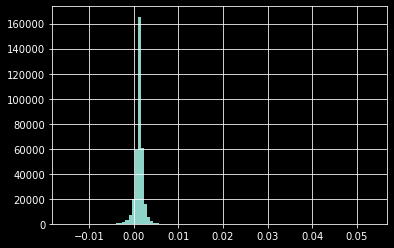

In [5]:
df_test['yhat'].hist(bins = 100);

In [6]:
def equal_weight_allocation(daily_predictions, notional = 1e6):
    return notional / len(daily_predictions)

def equal_weight_neg_pos_allocation(daily_predictions, notional = 1e6):
    notional_per_stock = notional / len(daily_predictions)
#     daily_predictions = daily_predictions.values
    signal = np.where(daily_predictions >= 0, 1,
                     np.where(daily_predictions < 0, -1, 0))
    return notional_per_stock * signal

def kelly_allocation(daily_predictions, notional = 1e6):
    normalized_predictions = daily_predictions / daily_predictions.abs().sum()
    return normalized_predictions * notional

def top_bottom_allocation(daily_predictions, notional = 1e6, top_bottom_number = 5):
    notional_per_stock = notional / 2 * top_bottom_number
    n = len(daily_predictions)
    rank_predictions = daily_predictions.rank(pct = False, method = 'first')
    signal = np.where(rank_predictions < top_bottom_number, -1,
                      np.where(rank_predictions >= n - top_bottom_number, 1, 0))
    return notional_per_stock * signal

def top_allocation(daily_predictions, notional = 1e6, top_number = 20):
    notional_per_stock = notional / top_number
    rank_predictions = daily_predictions.rank(pct = False, method = 'first', ascending = False)
    signal = np.where(rank_predictions < top_number, 1, 0)
    return notional_per_stock * signal

In [8]:
def eval_allocation_method(df_test, allocation_method):
    df_test.loc[:, 'notional'] = df_test.groupby('date')['yhat'].transform(allocation_method)

    df_test.eval("pnl = notional * target", inplace = True)

    pnl = df_test.groupby('date')['pnl'].sum()
    sharpe = pnl.mean()/pnl.std() * 252**0.5

    pnl.cumsum().plot()
    print(f'sharpe: {sharpe}')

In [10]:
df_test.query("date > '2015-01-01'", inplace = True)

sharpe: 0.7159011521012836


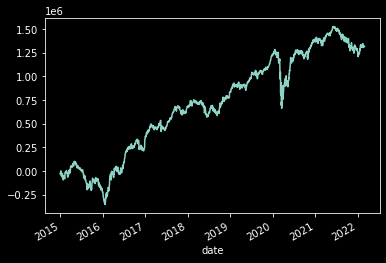

In [55]:
eval_allocation_method(df_test, equal_weight_allocation)

sharpe: 0.8394691143917596


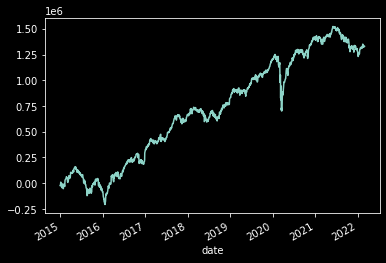

In [56]:
eval_allocation_method(df_test, equal_weight_neg_pos_allocation)

sharpe: 0.9586173434916613


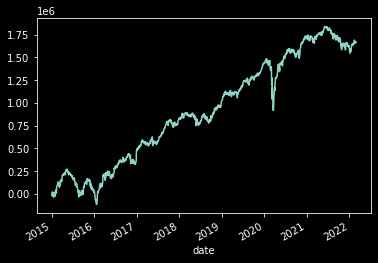

In [57]:
eval_allocation_method(df_test, kelly_allocation)

sharpe: 0.6546656975922387


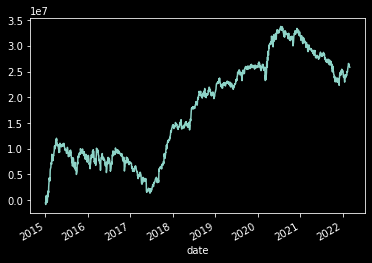

In [61]:
eval_allocation_method(df_test, top_bottom_allocation)

sharpe: 0.9434192141780513


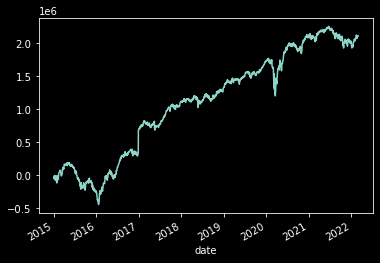

In [11]:
eval_allocation_method(df_test, top_allocation)